In [1]:
# imports
from copy import deepcopy
import numpy as np
from statistics import mean

import sys
sys.path.append('../src/')

from classification import get_stumps, get_scipy_selected_stumps
from evaluation import central_train_accuracy, central_test_accuracy, edges, central_loss, random_accuracy, maj_class_accuracy, best_accuracy
from network import null_graph, get_alphas, graph
from related_works import colearning, lafond_FW
from optimization import graph_discovery_sparse, regularized_local_FW, local_FW, global_regularized_local_FW, gd_reg_local_FW, centralized_FW
from utils import load_school, get_min_max

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# set graph of nodes with local personalized data
NB_ITER = 1000
n = 112

MU = 1
BETA = 1

X, Y, X_test, Y_test, adjacency, distances, K, max_nb_instances = load_school(path="../datasets/", thr=20, split=1)
D = X[0].shape[1]

# get nodes
nodes = graph(X, Y, X_test, Y_test, K, adjacency, distances, max_nb_instances)

# set monitors for optimization analysis
monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'loss': [central_loss, []],
}

# get weak classifiers
vmin, vmax = get_min_max(X)
base_clfs = get_stumps(n=n, d=D, min_v=vmin, max_v=vmax)

results = {}

In [5]:
centralized_nodes = deepcopy(nodes)
centralized_FW(centralized_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["global l1 Adaboost"] = {}
results["global l1 Adaboost"]["train-accuracy"] = central_train_accuracy(centralized_nodes)
results["global l1 Adaboost"]["test-accuracy"] = central_test_accuracy(centralized_nodes)

local_nodes = deepcopy(nodes)
local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["purely local models"] = {}
results["purely local models"]["train-accuracy"] = central_train_accuracy(local_nodes)
results["purely local models"]["test-accuracy"] = central_test_accuracy(local_nodes)

In [16]:
results["personalized linear"], clf_colearning = colearning(K, X, Y, X_test, Y_test, D, 5000, adjacency, distances, mu=MU, max_samples_per_node=max_nb_instances, checkevery=100)

In [8]:
reg_nodes = deepcopy(nodes)
results["Dada"] = regularized_local_FW(reg_nodes, base_clfs, nb_iter=5000, beta=BETA, mu=1, monitors=monitors, checkevery=100)

In [20]:
# initialize with local models
init_w = graph_discovery_sparse(local_nodes, 8)
gd_nodes = deepcopy(nodes)
results["Dada gd"] = gd_reg_local_FW(gd_nodes, base_clfs, init_w, gd_method={"name":"laplacian", "pace_gd": 100, "args":(8)}, beta=BETA, mu=1, reset_step=False, nb_iter=5000, monitors=monitors, checkevery=100)

In [ ]:
rnd_nodes = deepcopy(nodes)
rnd_accs = random_accuracy(rnd_nodes)
results["random"] = {}
results["random"]["train-accuracy"] = rnd_accs[0]
results["random"]["test-accuracy"] = rnd_accs[1]

In [ ]:
maj_nodes = deepcopy(nodes)
maj_accs = maj_class_accuracy(maj_nodes)
results["maj class"] = {}
results["maj class"]["train-accuracy"] = maj_accs[0]
results["maj class"]["test-accuracy"] = maj_accs[1]

In [14]:
best_nodes = deepcopy(nodes)
best_accs = best_accuracy(best_nodes)
results["gradient boosting local"] = {}
results["gradient boosting local"]["train-accuracy"] = best_accs[0]
results["gradient boosting local"]["test-accuracy"] = best_accs[1]

In [ ]:
base_clfs, _ = get_scipy_selected_stumps(X, Y, D)

centralized_nodes = deepcopy(nodes)
results["global scipy stumps"] = centralized_FW(centralized_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors=monitors, checkevery=10)
# results["global l1 Adaboost"] = {}
# results["global l1 Adaboost"]["train-accuracy"] = central_train_accuracy(centralized_nodes)
# results["global l1 Adaboost"]["test-accuracy"] = central_test_accuracy(centralized_nodes)

local_nodes = deepcopy(nodes)
results["local scipy stumps"] = local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors=monitors, checkevery=10)
# results["purely local models"] = {}
# results["purely local models"]["train-accuracy"] = central_train_accuracy(local_nodes)
# results["purely local models"]["test-accuracy"] = central_test_accuracy(local_nodes)

# results["personalized linear"], clf_colearning = colearning(K, X, Y, X_test, Y_test, D, NB_ITER, adj_matrix, similarities, mu=MU, max_samples_per_node=max_nb_instances)

# Accuracy and Convergence

global l1 Adaboost 0.697236509459
gradient boosting local 0.771074884491
purely local models 0.741434922849


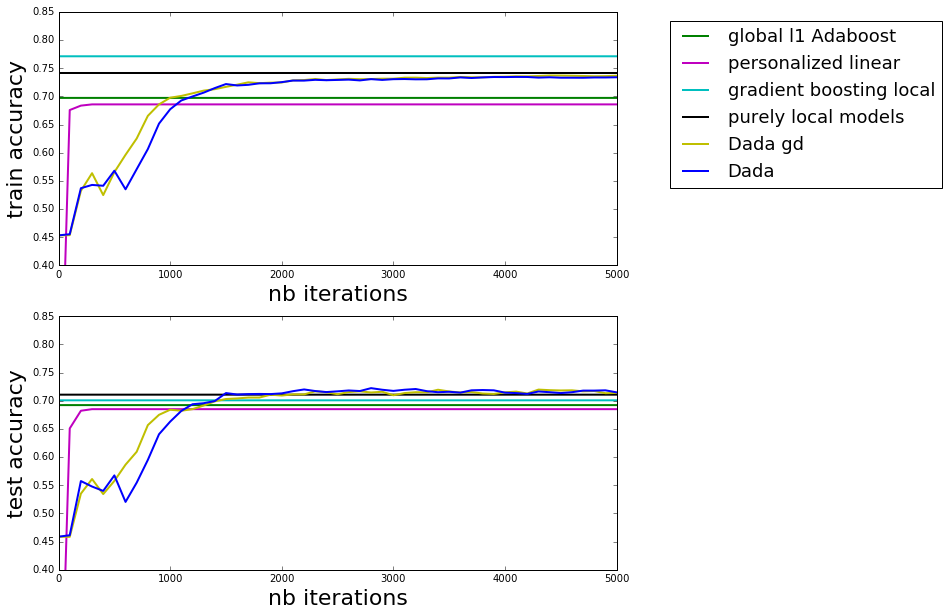

In [21]:
plt.figure(1, figsize=(10, 10))

colors = {
    "Dada": "b",
    "global l1 Adaboost": "g",
    "purely local models": "k",
    "Dada gd": "y",
    "personalized linear": "m", 
    "gradient boosting local": "c"
}

max_iter = 5000
plt.subplot(211)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('train accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.4, 0.85)

for k, r_list in results.items():
    try:
        c = 100
        plt.plot([i*c for i in range(len(r_list))], [r['train-accuracy'] for r in r_list], label='{}'.format(k), color=colors[k], linewidth=2)
    except:
        print(k, r_list['train-accuracy'])
        plt.plot(range(max_iter+1), [r_list['train-accuracy']]*(max_iter+1), label='{}'.format(k), color=colors[k], linewidth=2)

plt.legend(bbox_to_anchor=(1.6, 1), fontsize=18)

plt.subplot(212)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.4, 0.85)

for k, r_list in results.items():
    try:
        c = 100
        plt.plot([i*c for i in range(len(r_list))], [r['test-accuracy'] for r in r_list], label='{}'.format(k), color=colors[k], linewidth=2)
    except:
        plt.plot(range(max_iter+1), [r_list['test-accuracy']]*(max_iter+1), label='{}'.format(k), color=colors[k], linewidth=2)

# plt.legend(loc='lower right', fontsize=18)

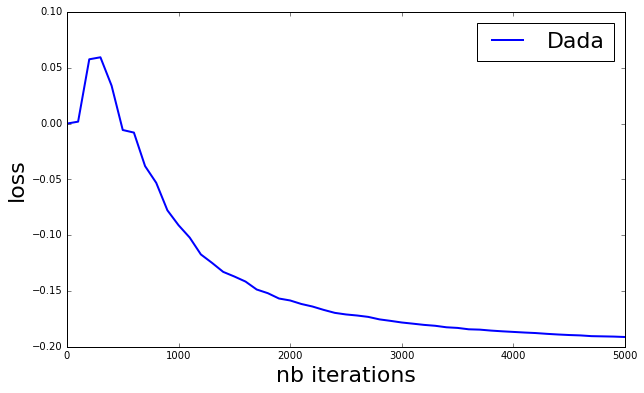

In [19]:
# convergence

max_iter = 10000
plt.figure(1, figsize=(10, 6))

plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('loss', fontsize=22)

for k, r_list in results.items():
    try:
        plt.plot([i*100 for i in range(len(r_list))], [r['loss'] for r in r_list], label='{}'.format(k), color=colors[k], linewidth=2)
    except:
        pass

plt.legend(loc='upper right', fontsize=22)